Imports

In [116]:
import torch
import torch.nn as nn
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
import math

MODEL

In [117]:
class LogisticRegression(nn.Module):
    def __init__(self, n_input=47, n_hidden = 64, n_output = 1):
        super(LogisticRegression, self).__init__()
        
        self.fc_block = nn.Sequential(
            nn.Linear(n_input, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, 16),
            nn.ReLU(),
            nn.Linear(16, n_output),
            nn.Sigmoid()
        )
    def forward(self, x):
        x = self.fc_block(x)
        return x



Dataset

In [118]:
class PassangerDataset(Dataset):
    def __init__(self):

        self.train = pd.read_csv('train.csv', index_col='PassengerId')
        
        X_train = self.train.drop(columns=['Name'])
        X_train[['Cabin_1', 'Cabin_2', 'Cabin_3']] = X_train['Cabin'].str.split('/').apply(pd.Series)
        X_train.drop(columns='Cabin', inplace=True)

        X_train['Cabin_2'] = X_train['Cabin_2'].astype(float)
        for group in range(1,1901,100):
            X_train[f'Cabin_2_{group}-{group+99}'] = (X_train['Cabin_2'] >= group) & (X_train['Cabin_2'] < (group+100))
        
        X_train = X_train.drop(columns='Cabin_2')

        numeric_columns = X_train.select_dtypes(include=['float', 'int'])
        
        X_train.fillna(numeric_columns.mean(), inplace=True)
        X_train.fillna(0.5, inplace=True)

        X_train = pd.get_dummies(X_train, columns=['HomePlanet', 'Destination', 'Cabin_1', 'Cabin_3'])
        self.y = torch.tensor(X_train['Transported'].values)
        
        x_float32 = X_train.drop('Transported', axis=1).values.astype('float32')
        x_not_norm = torch.tensor(x_float32, dtype=torch.float32).view(-1, x_float32.shape[1])

        min_vals = torch.min(x_not_norm, dim=0).values
        max_vals = torch.max(x_not_norm, dim=0).values

        normalized_matrix = (x_not_norm - min_vals) / (max_vals - min_vals)


        self.x = normalized_matrix
    def __getitem__(self, index):
        return self.x[index],self.y[index]

    def __len__(self):
        return len(self.train)

Utility functions

In [119]:
def calculate_accuracy(model, dataloader):
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model(inputs)
            predicted = (outputs >= 0.5).float()
            labels = labels.view(-1,1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

Neural network training

In [120]:
dataset = PassangerDataset()

total_samples = len(dataset)
train_size = int(0.8 * total_samples)

train_dataset, test_dataset = random_split(dataset, [train_size, total_samples - train_size])

batch_size = 256
train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)


model = LogisticRegression(47)
loss_function = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

total_samples = len(train_dataset)
n_iterations = math.ceil(total_samples/batch_size)

num_epochs = 100
loss_history = []
for epoch in range(num_epochs):
    total_loss = 0.0

    for i, (inputs, labels) in enumerate(train_dataloader):
        # Forward pass
        y_predicted = model(inputs)
        y = labels.float().view(-1,1)
        loss = loss_function(y_predicted, y)
        loss_history.append(loss.item())
        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()


    average_loss = total_loss / n_iterations
    print(f'Epoch {epoch + 1} - Average Loss: {average_loss:.4f}')

    test_accuracy = calculate_accuracy(model,test_dataloader)
    print(f'Testing Accuracy: {test_accuracy:.2f}%')

print('Training completed.')


Epoch 1 - Average Loss: 0.6861
Testing Accuracy: 70.21%
Epoch 2 - Average Loss: 0.6479
Testing Accuracy: 71.59%
Epoch 3 - Average Loss: 0.5754
Testing Accuracy: 73.03%
Epoch 4 - Average Loss: 0.5275
Testing Accuracy: 74.01%
Epoch 5 - Average Loss: 0.5139
Testing Accuracy: 74.70%
Epoch 6 - Average Loss: 0.4970
Testing Accuracy: 75.22%
Epoch 7 - Average Loss: 0.4852
Testing Accuracy: 75.62%
Epoch 8 - Average Loss: 0.4729
Testing Accuracy: 75.96%
Epoch 9 - Average Loss: 0.4611
Testing Accuracy: 76.08%
Epoch 10 - Average Loss: 0.4510
Testing Accuracy: 77.06%
Epoch 11 - Average Loss: 0.4395
Testing Accuracy: 77.11%
Epoch 12 - Average Loss: 0.4322
Testing Accuracy: 77.92%
Epoch 13 - Average Loss: 0.4223
Testing Accuracy: 78.32%
Epoch 14 - Average Loss: 0.4185
Testing Accuracy: 77.86%
Epoch 15 - Average Loss: 0.4107
Testing Accuracy: 78.72%
Epoch 16 - Average Loss: 0.4112
Testing Accuracy: 78.15%
Epoch 17 - Average Loss: 0.3979
Testing Accuracy: 78.03%
Epoch 18 - Average Loss: 0.3935
Testing 

Test data cleaning

In [86]:
target = pd.read_csv('sample_submission.csv')
test = pd.read_csv('test.csv')
test_passenger_ids = test['PassengerId']


X_test = test.drop(columns=['Name','PassengerId'])
X_test[['Cabin_1', 'Cabin_2', 'Cabin_3']] = X_test['Cabin'].str.split('/').apply(pd.Series)
X_test.drop(columns='Cabin', inplace=True)

X_test['Cabin_2'] = X_test['Cabin_2'].astype(float)
for group in range(1,1901,100):
    X_test[f'Cabin_2_{group}-{group+99}'] = (X_test['Cabin_2'] >= group) & (X_test['Cabin_2'] < (group+100))
X_test = X_test.drop(columns='Cabin_2')

numeric_columns = X_test.select_dtypes(include=['float', 'int'])
X_test.fillna(numeric_columns.mean(), inplace=True)
X_test.fillna(0.5, inplace=True)

X_test = pd.get_dummies(X_test, columns=['HomePlanet', 'Destination', 'Cabin_1', 'Cabin_3'])
x_float32 = X_test.values.astype('float32')
X_test = torch.tensor(x_float32,dtype=torch.float32,requires_grad=True)


Submission

In [114]:
import csv

with torch.no_grad():
    predictions = model(X_test)
    predictions = (predictions >= 0.5)
predictions = predictions.squeeze()
predictions = predictions.numpy()
with open('submission.csv','w') as f:
    writer = csv.writer(f)
    header = ['PassengerId','Transported']
    writer.writerow(header)
    f.flush()
    writer.writerows(zip(test_passenger_ids,predictions))
    f.flush()

Loss history

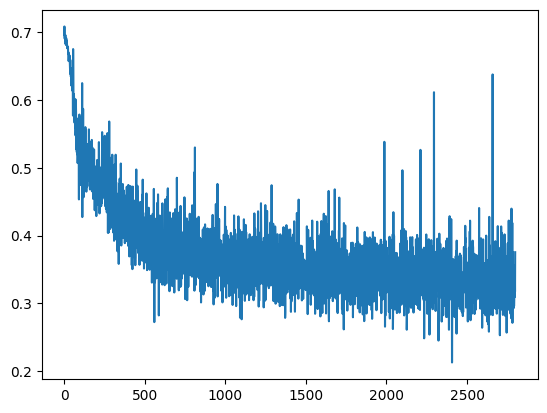

In [115]:
plt.plot(loss_history)